In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

2024-11-18 15:15:59.813021: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


No GPU was detected. CNNs can be very slow without a GPU.


In [3]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

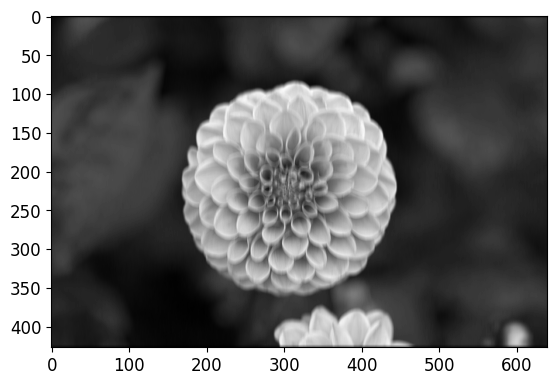

In [3]:
from sklearn.datasets import load_sample_image

#Load sample images
china = load_sample_image('china.jpg') / 255
flower = load_sample_image('flower.jpg') / 255
images = np.array([china,flower])
batch_size, height, width, channels = images.shape

#Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 #vertical line
filters[3, :, :, 1] = 1 #horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding='SAME')

plt.imshow(outputs[1, :, :, 0], cmap='gray') #plotting the first images, second feature map
plt.show()

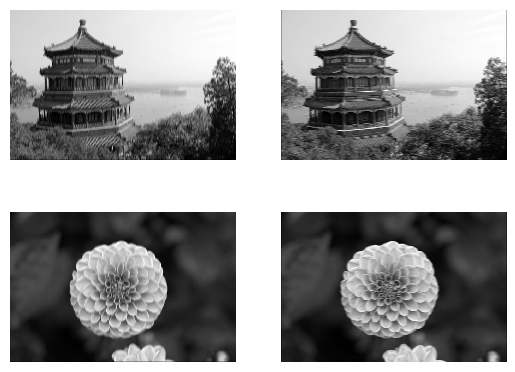

In [4]:
for image_index in (0,1):
    for feature_map_index in (0,1):
        plt.subplot(2,2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])
plt.show()

In [5]:
#In a real CNN you would typically define filters as trainable variables

#Creates a Conv2D layer with 32 filters, 3x3 each
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='SAME', activation='relu')
conv_outputs = conv(images) 
conv_outputs.shape

TensorShape([2, 427, 640, 32])

(2, 213, 320, 3)


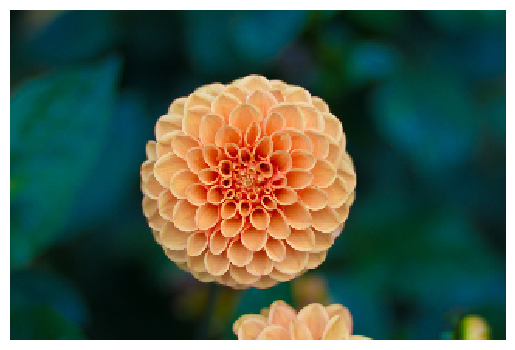

In [6]:
# Max Pooling layer
max_pool = keras.layers.MaxPool2D(pool_size=2)
max_pool_ouputs = max_pool(images)
plot_image(max_pool_ouputs[1])
print(max_pool_ouputs.shape)

(2, 213, 320, 3)


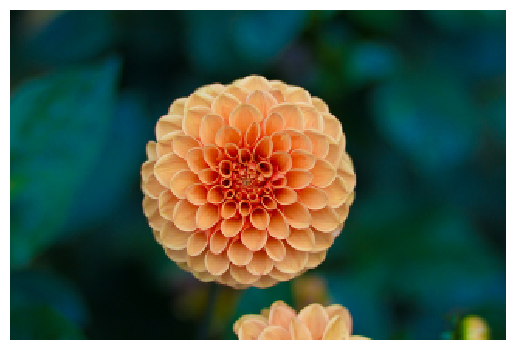

In [7]:
#Average Pooling layer
avg_pool = keras.layers.AvgPool2D(pool_size=2)
avg_pool_ouputs = avg_pool(images)
plot_image(avg_pool_ouputs[1])
print(avg_pool_ouputs.shape)

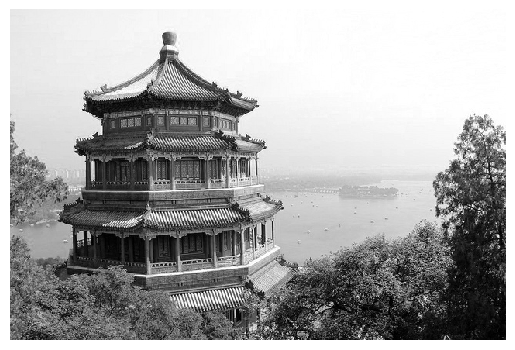

In [8]:
#Depth-wise pooling
depth_output= tf.nn.max_pool(images,
                             ksize=(1,1,1,3),
                             strides=(1,1,1,3),
                             padding='VALID')
plot_image(depth_output[0])

#To include as a layer in Keras models
depth_pool = keras.layers.Lambda(
    lambda X: tf.nn.max_pool(X, ksize=(1,1,1,3), strides=(1,1,1,3), padding='VALID')
)

In [9]:
#Global Average Pooling layer
global_avg_pool = keras.layers.GlobalAvgPool2D()

#or..

global_avg_pool = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1,2]))

In [10]:
#Simple CNN Architectures w/ Fashion MNIST

#Load the data
(X_train_full, y_train_full), (X_test, y_test) =  keras.datasets.fashion_mnist.load_data()
X_train, X_val = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_val = y_train_full[:-5000], y_train_full[-5000:]

#Build model
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation='relu', padding='SAME', input_shape=[28,28,1]),  #First layer uses 64 7x7 filters but no stride due to small input size shape
    keras.layers.MaxPooling2D(2), #Max Pooling with size of 2 that divides each spatial dimension by a factor of 2
    keras.layers.Conv2D(128, 3, activation='relu', padding='SAME'), #2 convolutional layers followed by a Max Pooling layer - 128 filters (3x3)
    keras.layers.Conv2D(128, 3, activation='relu', padding='SAME'), #Common practice to double the amount of filters after each pooling layer
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation='relu', padding='SAME'), #2 convolutional layers followed by a Max Pooling layer - 256 filters (3x3)
    keras.layers.Conv2D(256, 3, activation='relu', padding='SAME'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(), #Fully connected network
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5), #Dropout layer to avoid overfitting
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

#Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=2, validation_data=(X_val, y_val))

Epoch 1/2


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 245s 141ms/step - accuracy: 0.5848 - loss: 1.2453 - val_accuracy: 0.8550 - val_loss: 0.4160
Epoch 2/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 241s 140ms/step - accuracy: 0.8235 - loss: 0.5180 - val_accuracy: 0.8720 - val_loss: 0.3633


In [11]:
#The LeNet-5 Architecture

#Build model
model = keras.models.Sequential([
    # keras.layers.Input(shape=[32,32,1]),
    keras.layers.Conv2D(filters=6, kernel_size=5, strides = 1, activation='tanh', padding='VALID', input_shape=[28,28,1]),
    keras.layers.AvgPool2D(pool_size=2, strides=2), 
    keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, activation='tanh', padding='VALID'), 
    keras.layers.AvgPool2D(pool_size=2, strides=2), 
    keras.layers.Conv2D(filters=120, kernel_size=5, strides= 1, activation='tanh', padding='SAME'), 
    keras.layers.Flatten(), 
    keras.layers.Dense(units=84, activation='relu'),
    keras.layers.Dense(units=10, activation='softmax')
])

model.summary()

# #Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=2, validation_data=(X_val, y_val))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 12, 12, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 16)       │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 4, 4, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 120)      │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 84)             │       161,364 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,906 (831.66 KB)

 Trainable params: 212,906 (831.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.7882 - loss: 0.5776 - val_accuracy: 0.8700 - val_loss: 0.3576
Epoch 2/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.8641 - loss: 0.3676 - val_accuracy: 0.8738 - val_loss: 0.3481


In [ ]:
#Importing ImageNet Mini from Kaggle
# train_dir = '/Users/colingibbons-fly/Downloads/imagenet-mini 3/train' 

# train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     train_dir,
#     image_size=(224, 224),  # Resize images to 224x224, typical for models like AlexNet
#     batch_size=32,          # Choose an appropriate batch size based on your memory
#     label_mode='int'        # Labels as integers (for categorical cross-entropy)
# )

# # View the dataset info
# for images, labels in train_dataset.take(1):
#     print("Image batch shape:", images.shape)
#     print("Label batch shape:", labels.shape)

# val_dir = '/Users/colingibbons-fly/Downloads/imagenet-mini 3/val'  # Replace with the actual path to your "test" directory

# test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     val_dir,
#     image_size=(224, 224),  # Same size as used for training
#     batch_size=32,          # Same batch size or adjust as needed
#     label_mode='int'        # Same label mode
# )

# # View the dataset info
# for images, labels in test_dataset.take(1):
#     print("Test image batch shape:", images.shape)
#     print("Test label batch shape:", labels.shape)

# # Extract X_train and y_train from train_dataset
# X_train = []
# y_train = []
# for images, labels in train_dataset:
#     X_train.append(images)
#     y_train.append(labels)

# X_train = np.concatenate(X_train, axis=0)
# y_train = np.concatenate(y_train, axis=0)

# # Extract X_test and y_test from test_dataset
# X_test = []
# y_test = []
# for images, labels in test_dataset:
#     X_test.append(images)
#     y_test.append(labels)

# X_test = np.concatenate(X_test, axis=0)
# y_test = np.concatenate(y_test, axis=0)

In [13]:
#The AlexNet Architecture

#Build model
model = keras.models.Sequential([
    keras.layers.Input(shape=[227,227,3]),
    keras.layers.Conv2D(filters=96, kernel_size=11, strides = 4, activation='relu', padding='VALID'),
    keras.layers.MaxPooling2D(pool_size=3, strides=2), 
    keras.layers.Conv2D(filters=256, kernel_size=5, strides=1, activation='relu', padding='SAME'), 
    keras.layers.MaxPooling2D(pool_size=2, strides=2), 
    keras.layers.Conv2D(filters=384, kernel_size=3, strides= 1, activation='relu', padding='SAME'), 
    keras.layers.Conv2D(filters=384, kernel_size=3, strides= 1, activation='relu', padding='SAME'), 
    keras.layers.Conv2D(filters=256, kernel_size=3, strides= 1, activation='relu', padding='SAME'), 
    keras.layers.Flatten(),
    keras.layers.Dense(units=4096, activation='relu'),
    keras.layers.Dense(units=4096, activation='relu'),
    keras.layers.Dense(units=1000, activation='softmax')
])

# #Compile the model
# model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
# history = model.fit(X_train, y_train, epochs=3, validation_data=(X_test, y_test))

In [14]:
#ResNet-34 Arcitecture

#Load the data
(X_train_full, y_train_full), (X_test, y_test) =  keras.datasets.fashion_mnist.load_data()
X_train, X_val = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_val = y_train_full[:-5000], y_train_full[-5000:]

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides, padding='SAME', use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1, padding='SAME', use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides, padding='SAME', use_bias=False),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)
    

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[28,28,1], padding='SAME', use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation='softmax'))

# #Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=2, validation_data=(X_test, y_test))

Epoch 1/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2085s 1s/step - accuracy: 0.7728 - loss: 0.7249 - val_accuracy: 0.8519 - val_loss: 0.4346
Epoch 2/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2073s 1s/step - accuracy: 0.8716 - loss: 0.3548 - val_accuracy: 0.8624 - val_loss: 0.4099


In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
#Using Pretrained Models from Keras

#Resnet 50 example
model = keras.applications.resnet50.ResNet50(weights='imagenet')

In [3]:
#Pretrained models for Transfer Learning
import tensorflow_datasets as tfds

dataset, info = tfds.load('tf_flowers', as_supervised=True, with_info=True)
dataset_size = info.splits['train'].num_examples
class_names = info.features['label'].names
n_classes = info.features['label'].num_classes

In [4]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

2024-11-18 15:16:12.078420: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-11-18 15:16:12.087438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


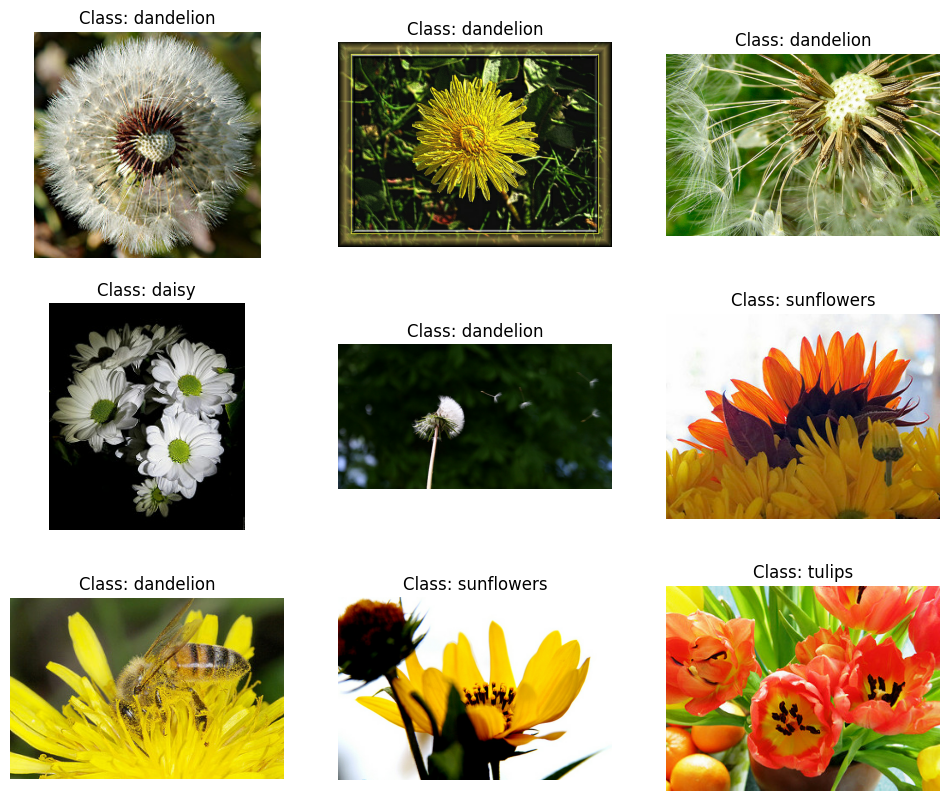

In [5]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [6]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [7]:
batch_size = 32
train_set = train_set_raw.shuffle(1000)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [8]:
base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation='softmax')(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

In [9]:
#Freeze weights on pre-trained layer for beginning of training
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


86/86 ━━━━━━━━━━━━━━━━━━━━ 299s 3s/step - accuracy: 0.7433 - loss: 1.2801 - val_accuracy: 0.8585 - val_loss: 1.1357
Epoch 2/5


2024-11-18 15:21:23.661908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-11-18 15:21:24.504252: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8571 - val_loss: 0.3971
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 299s 3s/step - accuracy: 0.8942 - loss: 0.7359 - val_accuracy: 0.8290 - val_loss: 1.4208
Epoch 4/5


2024-11-18 15:26:23.738339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8571 - val_loss: 0.8880
Epoch 5/5


2024-11-18 15:26:24.270268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


86/86 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.9197 - loss: 0.4363 - val_accuracy: 0.8529 - val_loss: 1.5524


In [10]:
#After training the model for a few epochs, unfreeze all the layers
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


86/86 ━━━━━━━━━━━━━━━━━━━━ 1485s 17s/step - accuracy: 0.8184 - loss: 0.7109 - val_accuracy: 0.8382 - val_loss: 0.7684
Epoch 2/5


2024-11-18 15:55:53.468785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-11-18 15:55:54.166217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8571 - val_loss: 0.6544
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 1655s 19s/step - accuracy: 0.9675 - loss: 0.1072 - val_accuracy: 0.9044 - val_loss: 0.3956
Epoch 4/5


2024-11-18 16:23:29.573620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-18 16:23:30.651165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0441
Epoch 5/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 1411s 16s/step - accuracy: 0.9934 - loss: 0.0232 - val_accuracy: 0.8879 - val_loss: 0.4245


In [14]:
#Classification and Localization

base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation='softmax')(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.Model(inputs=base_model.input, outputs=[class_output, loc_output])

model.compile(loss=['sparse_categorical_crossentropy', 'mse'],
              loss_weights=[0.8, 0.2],
              optimizer=optimizer, metrics=['accuracy'])